# Running patch dynamics in the restricted path integral (RPI) approach

In this tutorial, we conduct patch dynamics calculations for the restricted path integral (RPI) approach. A patch refers to a time segment of the total time duration for an NBRA trajectory. In RPI, the electronic dynamics of each patch — patch dynamics — are eventually summed to yield the overall population dynamics (see `20_step5_sum_rpi/` for this patch summation). The patch dynamics is governed by the coherent Ehrenfest propagation and needs to be conducted repetitively, wherein the initial state is set to each of the pure states. The population from each patch dynamics serves as a transition probability from a given intial state.

The RPI calculations presented in `19_step4_patch_rpi/` (this tutorial) and `20_step5_sum_rpi/` can be considered a further reduction of the conventional step4 NBRA-TSH dynamics calculations (examples can be found in `5_step4/`, `9_step4/`, and `15_step4_bllz/`), as the electronic dynamics is simplified by tracking only electronic populations. Thus, for this tutorial, the NBRA procedures from step 1 to step 3 — predefining a nuclear trajectory and computing electronic properties such as molecular overlap, time overlap and nonadiabatic coupling between a given electronic basis — needs to be done first.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
   
2. [Overview of required files](#2)

3. [Run the patch dynamics](#3)

## A. Learning objectives
* To be able to run the patch dynamics for the population dynamics in the restricted path integral approach

## B. Use cases

* [Run NAMD simulations](#run_namd)
* [Plot results](#plot_res)

## C. Functions
- `libra_py`
  - `workflow`
    - `nbra`
      - `rpi`
        - [`run_patch_rpi`](#run_namd)
  - `dynamics`
    - `tsh`
      - `plot`
        - [`plot_dynamics`](#plot_res)
  - `units`
    - [`fs2au`](#run_namd)

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [17]:
import os
import matplotlib.pyplot as plt   # plots
import numpy as np
import h5py
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units, data_conv
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot

from libra_py.workflows.nbra import rpi

#from matplotlib.mlab import griddata
#%matplotlib inline 
#warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13", "23", "14", "24"]

## 2. Overview of required files<a name="2"></a>
[Back to TOC](#toc)

The following file is needed to run the patch dynamics.

* `run_template.py`

A template file for running a patch dynamics.

* `submit_template.slm`

A template file for submitting the job that runs `python run.py`. The `run.py` file is a copy of the `run_template.py` where the initial conditions and initial state varies.

* `../8_step3/1_DFT/res-mb-sd-DFT`

The path of the vibronic Hamiltonian files. In this example, we use the energies and nonadiabatic couplings (NACs) between the many-body (MB) basis for the Rutile TiO2 system.

## 3. Run the patch dynamics<a name="3"></a>
[Back to TOC](#toc)

To run the RPI dynamics, we need to set up the patch dynamics first. According to the parameter below, the patch dynamics will be conducted by running the function `rpi.run_patch_dyn(params_rpi_patch)`

The parameters in this file are as follows:

`run_slurm`: Whether to use the slurm environment to submit the jobs using the `submit_template file`. If it is set to `False`, it will run the calculations on the active session but multiple jobs will be run on the current active session. 

`submit_template`: The path of a template slurm submit file.

`run_python_file`: The path of a template running script.

`path_to_save_Hvibs`: The path of the vibronic Hamiltonian files.

`submission_exe`: The submission executable

`iread`: The initial step to read the vibronic Hamiltonian and time overlap

`fread`: The final step to read the vibronic Hamiltonian and time overlap

`iconds`: The list of initial step indices from the trajectory segment from `iread` to `fread`. Each initial condition characterizes each batch.

`nsteps`: The total number of RPI simulation steps

`npatches`: The number of patches. The time duration of each patch dynamics will be `int(nsteps/npatches) + 1`. The additional single step is because the tsh recipe (see `libra_py.dynamics.tsh.compute` for details) used for the patch dynamics saves the dynamics information before the electron-nuclear propagation in each MD loop.

`nstates`: The number of electronic states.

`dt`: the time step in the atomic unit.

`path_to_save_patch`: The path of the output patch dynamics

Note that

* `fread` needs to be equal to or greater than `iread + max(iconds) + nsteps + 1` to cover the electronic information for patch dynamics.

* Technically, `nsteps` does not have to be divisible by `npatches`. However, if `nsteps` is not divisible by `npatches`, the electronic propagation in the last time segment — that is, from `int(nsteps / npatches) * npatches` to `nsteps` — will be discarded in the final patch summation, in `20_step5_sum_rpi/`. 

In [ ]:
rpi_params = { 'run_slurm': False, 'submit_template': 'submit_template.slm', 'run_python_file': 'run_template.py', 'submission_exe': 'sbatch',
              'path_to_save_Hvibs': os.getcwd() + '/../8_step3/1_DFT/res-mb-sd-DFT', 'iread': 1200, 'fread': 1301, 'iconds': [0, 25, 50],
              'nsteps': 50, 'npatches': 2, 'nstates': 11, 'dt': 1.0*units.fs2au, 'path_to_save_patch': 'SAVE_PATCH0'  
            }

rpi.run_patch_rpi(rpi_params)

After the patch dynamics calculation, the data are saved in `job_X_Y_Z` directories. Here, `X`, `Y` and `Z` stands for the initial geometry index defined in `rpi_params["iconds"]`, the patch index from `0` to `rpi_params["npatches"] - 1`, the initial state index from `0` to `rpi_params["nstates"] - 1`.

In [4]:
! ls -F
! ls -F SAVE_PATCH0

SAVE_PATCH0/  run_template.py  submit_template.slm  tutorial_patch.ipynb
job_0_0_0/   job_0_1_0/   job_1_0_0/   job_1_1_0/   job_2_0_0/	 job_2_1_0/
job_0_0_1/   job_0_1_1/   job_1_0_1/   job_1_1_1/   job_2_0_1/	 job_2_1_1/
job_0_0_10/  job_0_1_10/  job_1_0_10/  job_1_1_10/  job_2_0_10/  job_2_1_10/
job_0_0_2/   job_0_1_2/   job_1_0_2/   job_1_1_2/   job_2_0_2/	 job_2_1_2/
job_0_0_3/   job_0_1_3/   job_1_0_3/   job_1_1_3/   job_2_0_3/	 job_2_1_3/
job_0_0_4/   job_0_1_4/   job_1_0_4/   job_1_1_4/   job_2_0_4/	 job_2_1_4/
job_0_0_5/   job_0_1_5/   job_1_0_5/   job_1_1_5/   job_2_0_5/	 job_2_1_5/
job_0_0_6/   job_0_1_6/   job_1_0_6/   job_1_1_6/   job_2_0_6/	 job_2_1_6/
job_0_0_7/   job_0_1_7/   job_1_0_7/   job_1_1_7/   job_2_0_7/	 job_2_1_7/
job_0_0_8/   job_0_1_8/   job_1_0_8/   job_1_1_8/   job_2_0_8/	 job_2_1_8/
job_0_0_9/   job_0_1_9/   job_1_0_9/   job_1_1_9/   job_2_0_9/	 job_2_1_9/


Each job directory contains `log` and the dynamics data in `out/mem_data.hdf`. The population in a patch can be visualized as follows. The patch dynamics employs the pure adiabatic initial conditions. Thus, we can see each patch dynamics directory contains the population dynamics with different initial states, as specified by `istate` below.

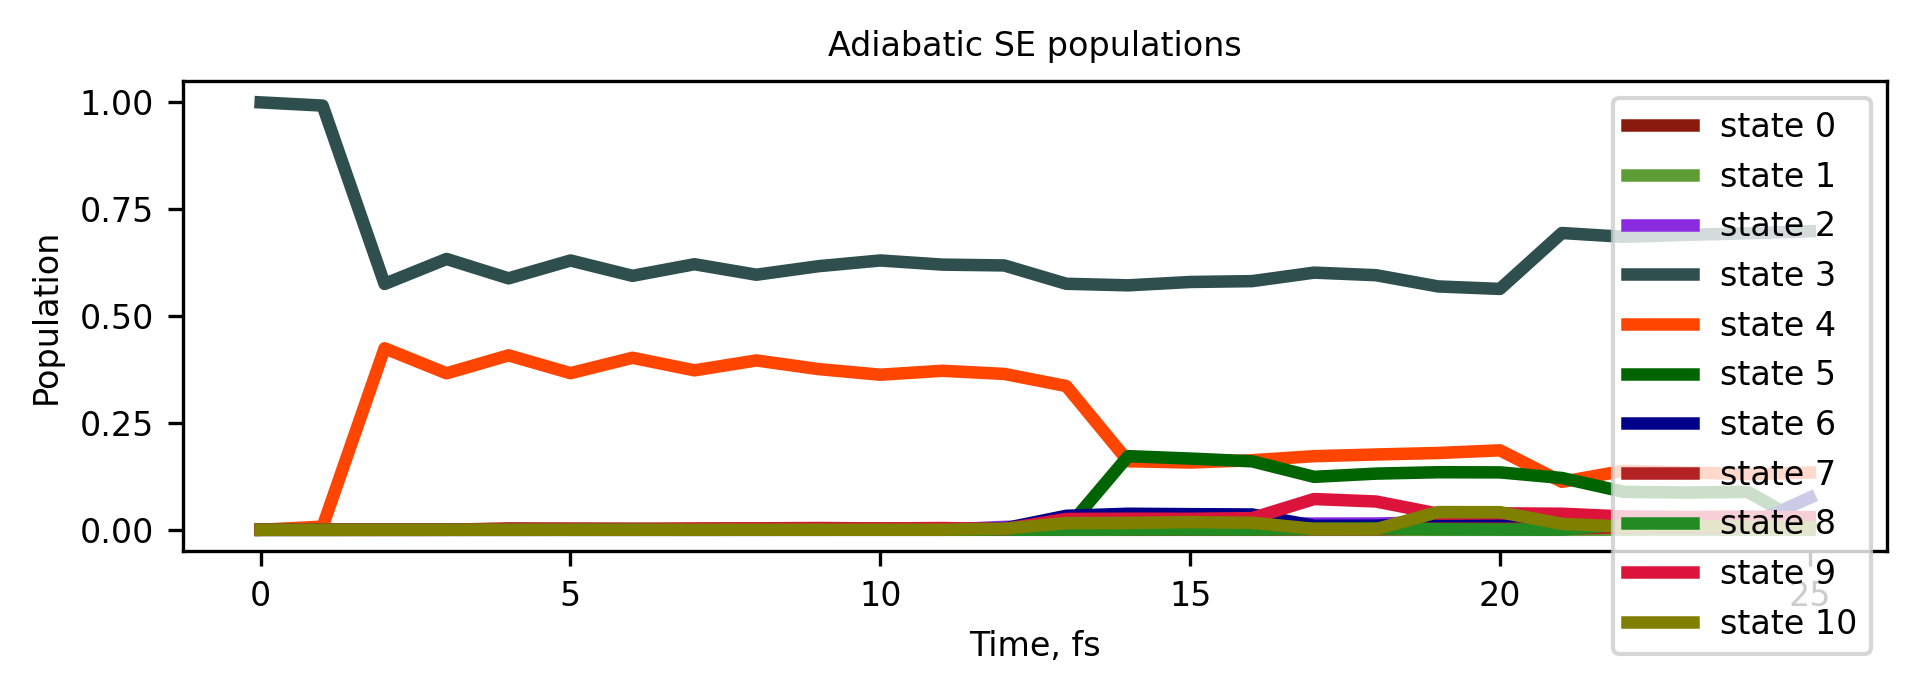

In [6]:
icond, ipatch, istate = 0, 0, 3

prefix = rpi_params['path_to_save_patch'] + F"/job_{icond}_{ipatch}_{istate}/out"

plot_params = { "prefix": prefix, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":0, "which_dofs":[0], "which_adi_states":list(range(rpi_params["nstates"])), 
                "which_dia_states":list(range(rpi_params["nstates"])), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi"], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":0, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

Various `npatches` can be utilized. Let's run a new set of patch dynamics with `npatches = 5`, and save the results in a new directory.  

In [ ]:
rpi_params.update({'npatches': 10, 'path_to_save_patch': 'SAVE_PATCH1'})

rpi.run_patch_rpi(rpi_params)

We can see that the time duration of the patch dynamics is shortened, i.e., `npatches = 10` and then the number of time steps is `int(nsteps/npatches) + 1 = 50/10 + 1`.

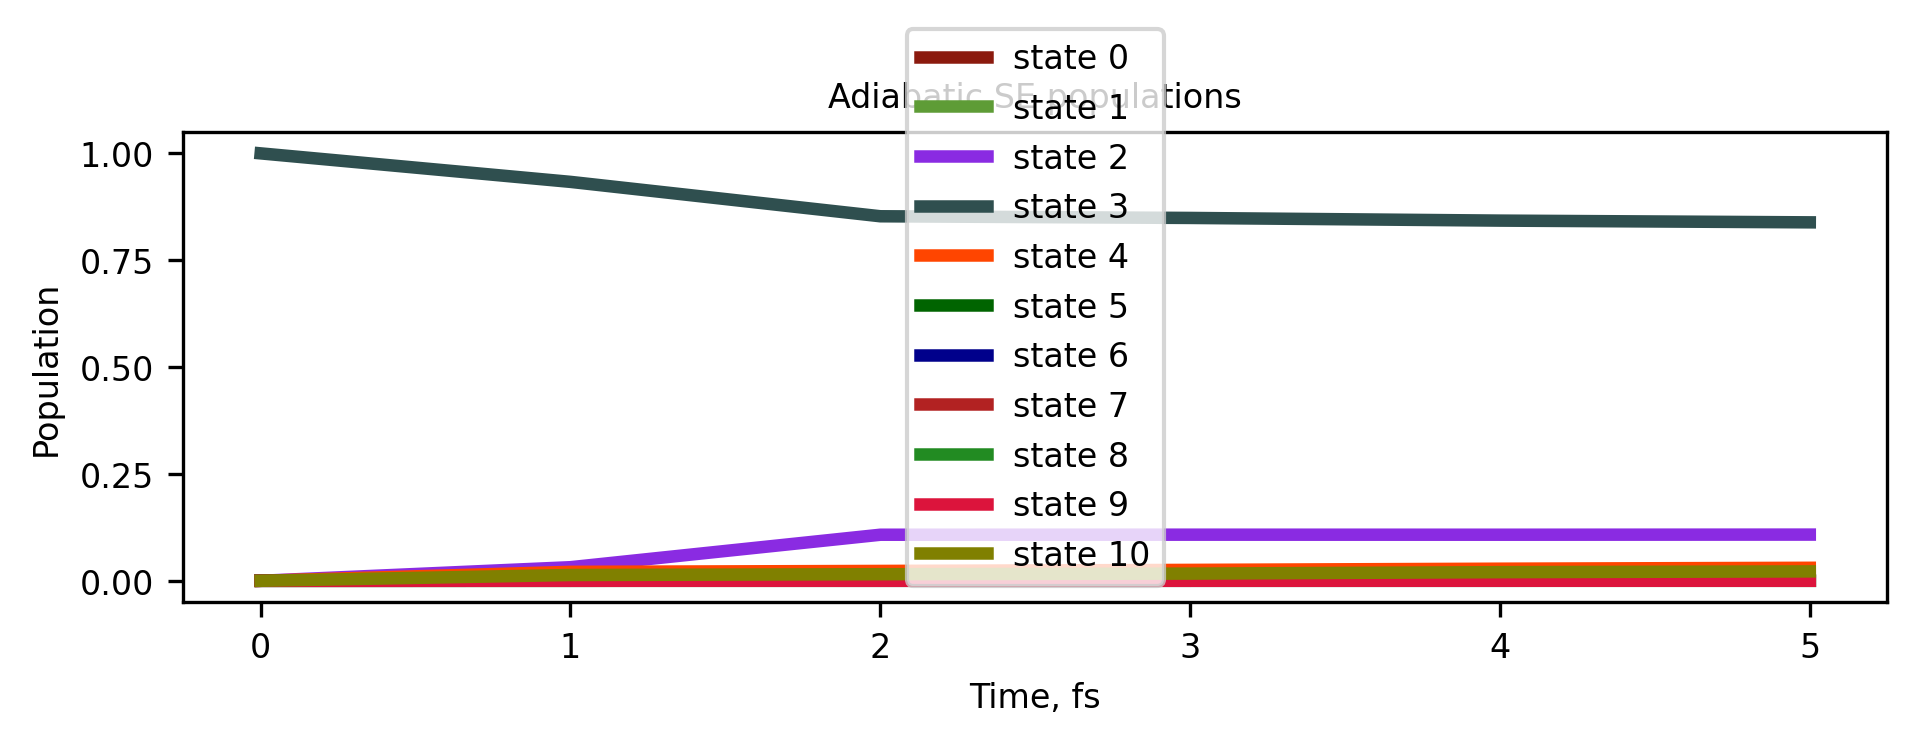

In [16]:
icond, ipatch, istate = 0, 4, 3

prefix = rpi_params['path_to_save_patch'] + F"/job_{icond}_{ipatch}_{istate}/out"

plot_params = { "prefix": prefix, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":0, "which_dofs":[0], "which_adi_states":list(range(rpi_params["nstates"])), 
                "which_dia_states":list(range(rpi_params["nstates"])), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi"], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":0, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

Eventually, individual patch dynamics will be summed to yield the global population, as explained in `20_step5_sum_rpi/`

### Exercise 1
Check the patch dynamics by changing the set of `icond`, `ipatch`, `istate` values. Especially, note that how the initial state is altered with respect to `istate`.

### Exercise 2
Explore various numbers of patches.